In [ ]:
#scvi doesn't work without next 3
%pip install pymde
%pip install leidenalg
%pip install igraph
%pip install --quiet gdown
%pip install seaborn
%pip install --quiet bbknn
%pip install pandas
%pip install ipywidgets
%pip install MulticoreTSNE
%pip install scipy
%pip install scikit-misc
#if you're going to install pytorch or JAX for accelerated computing do it before scvi
%pip install scanpy
%pip install anndata
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install nvidia-cuda-runtime-cu12
%pip install nvidia-<library>
%pip install -U scvi-tools

^C
Note: you may need to restart the kernel to use updated packages.




Import packages

In [1]:
import pathlib
import numpy as np
import scanpy as sc
import scanpy.external as sce
import pandas as pd

#pyscenic
import anndata as ad
from anndata.experimental.multi_files import AnnCollection
#specific requirements of pyscenic
import loompy as lp

## This is T-SNE, download has wheel error, could fix... could use UM
#from MulticoreTSNE import MulticoreTSNE as TSNE

#data vis
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import umap
#scvi
import leidenalg
import igraph
import pymde
import torch
import tempfile
import scvi




d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\

In [2]:
current_directory = pathlib.Path.cwd()
module_directory = current_directory.parent.parent

input_path = module_directory / "input"
scrna_metadata_path = input_path /"scRNA_metadata"

output_path = module_directory / 'output'
scrna_output = module_directory / 'output/integrated_scRNA'
other_output = output_path / 'scvi'
dataset_type = "heca_normal"

In [3]:
import shutil

total, used, free = shutil.disk_usage("/")
print(f"Total: {total // (2**30)} GiB")
print(f"Used: {used // (2**30)} GiB")
print(f"Free: {free // (2**30)} GiB")

Total: 931 GiB
Used: 345 GiB
Free: 585 GiB


In [ ]:

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
#save_dir = tempfile.TemporaryDirectory()
#%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
#%config InlineBackend.figure_format="retina"
!nvidia-smi

In [6]:


print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
	
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

#Garrett if this is false for you -- 
## run this in powershell (assuming windows/pip/python): pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
## OR just comment out the next block rewrite it without the accelerator. It will take longer

Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce GTX 1070


In [7]:
scvi.settings.seed = 0
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Seed set to 0


Data Exploration

In [4]:
combined_adata = sc.read(scrna_output/"heca_data_combined_on_disk.h5ad")
combined_adata.obs_names_make_unique()

MemoryError: Unable to allocate 6.14 GiB for an array with shape (1649327264,) and data type int32

In [ ]:
combined_adata.obs.head()


dataset
AAACCCAAGGCTTTCA-1  FRZFRESH_GX25_ES345
AAACCCACAAGCTCTA-1  FRZFRESH_GX25_ES345
AAACCCAGTACGGTTT-1  FRZFRESH_GX25_ES345
AAACCCAGTAGGACCA-1  FRZFRESH_GX25_ES345
AAACCCATCCCGAGGT-1  FRZFRESH_GX25_ES345

In [ ]:
import pandas as pd

#read text file into pandas DataFrame
df = pd.read_csv(scrna_metadata_path/'E-MTAB-14039.sdrf.txt', sep='\t', comment='#', on_bad_lines='skip')
#print(df.columns)
healthy_tissue = df[df['Characteristics[disease]'] == 'normal']['Source Name']

print(len(healthy_tissue))

32


In [9]:
#THIS WORKS BUT IS TOO SMALL
#combined_adata = combined_adata[~combined_adata.obs['dataset'].str.contains('Endo', na=False)]
combined_adata = combined_adata[combined_adata.obs['dataset'].isin(healthy_tissue)]
combined_adata.obs['dataset']

AAACCCAAGGCTTTCA-1      FRZFRESH_GX25_ES345
AAACCCACAAGCTCTA-1      FRZFRESH_GX25_ES345
AAACCCAGTACGGTTT-1      FRZFRESH_GX25_ES345
AAACCCAGTAGGACCA-1      FRZFRESH_GX25_ES345
AAACCCATCCCGAGGT-1      FRZFRESH_GX25_ES345
                              ...          
TTTGGTTGTTCTTCAT-1    UA_Endo9426400_FX1146
TTTGGTTTCACTCCGT-1    UA_Endo9426400_FX1146
TTTGGTTTCACTTGGA-1    UA_Endo9426400_FX1146
TTTGGTTTCCACGTCT-1    UA_Endo9426400_FX1146
TTTGGTTTCTCACTCG-1    UA_Endo9426400_FX1146
Name: dataset, Length: 135489, dtype: category
Categories (32, object): ['FRZFRESH_GX25_ES345', 'FRZFRESH_GX26_ES345', 'FRZFRESH_GX27_ES345', 'FRZFRESH_GX28_ES345', ..., 'UA_Endo12961682_SE03', 'UA_Endo13646709_SE06', 'UA_Endo9426399_FX1146', 'UA_Endo9426400_FX1146']

In [10]:
#from scipy import sparse

#sparse_X = sparse.csr_matrix(combined_adata.X)
#combined_adata.X = sparse_X

In [10]:


combined_adata.var.head()



Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3]

In [11]:
print(combined_adata.var_names)
combined_adata.X

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 468435424 stored elements and shape (135489, 36601)>

In [12]:
combined_adata.obs
#output_file = "output/integrated_data.h5ad"
#combined_adata.write(output_file) # might just be failing because it already exists

dataset
AAACCCAAGGCTTTCA-1    FRZFRESH_GX25_ES345
AAACCCACAAGCTCTA-1    FRZFRESH_GX25_ES345
AAACCCAGTACGGTTT-1    FRZFRESH_GX25_ES345
AAACCCAGTAGGACCA-1    FRZFRESH_GX25_ES345
AAACCCATCCCGAGGT-1    FRZFRESH_GX25_ES345
...                                   ...
TTTGGTTGTTCTTCAT-1  UA_Endo9426400_FX1146
TTTGGTTTCACTCCGT-1  UA_Endo9426400_FX1146
TTTGGTTTCACTTGGA-1  UA_Endo9426400_FX1146
TTTGGTTTCCACGTCT-1  UA_Endo9426400_FX1146
TTTGGTTTCTCACTCG-1  UA_Endo9426400_FX1146

[135489 rows x 1 columns]

## Quality Control

In [13]:
combined_adata.var['MT'] = combined_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)


combined_adata.obs.head()



C:\Users\Olaf\AppData\Local\Temp\ipykernel_29484\1254290072.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  combined_adata.var['MT'] = combined_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


dataset  n_genes_by_counts  total_counts  \
AAACCCAAGGCTTTCA-1  FRZFRESH_GX25_ES345               3737       15451.0   
AAACCCACAAGCTCTA-1  FRZFRESH_GX25_ES345               2225        4539.0   
AAACCCAGTACGGTTT-1  FRZFRESH_GX25_ES345               3379       11695.0   
AAACCCAGTAGGACCA-1  FRZFRESH_GX25_ES345               2307        6950.0   
AAACCCATCCCGAGGT-1  FRZFRESH_GX25_ES345               2487        7820.0   

                    total_counts_MT  pct_counts_MT  
AAACCCAAGGCTTTCA-1           1092.0       7.067504  
AAACCCACAAGCTCTA-1            212.0       4.670632  
AAACCCAGTACGGTTT-1           1544.0      13.202223  
AAACCCAGTAGGACCA-1            700.0      10.071942  
AAACCCATCCCGAGGT-1            658.0       8.414322

In [14]:
sc.pl.violin(
    combined_adata, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True
)

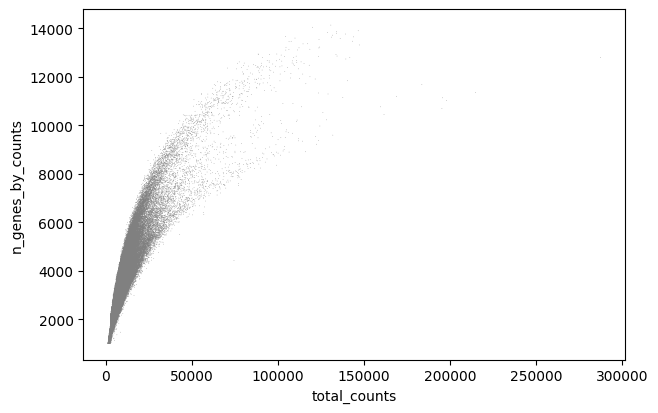

In [15]:
sc.pl.scatter(combined_adata, "total_counts", "n_genes_by_counts")

In [16]:
sc.pp.filter_cells(combined_adata, min_genes=100)
sc.pp.filter_genes(combined_adata, min_cells=3)

In [17]:
#skipping, I don't think doublets make sense to detect with dataset that has already been processed and integrated.
#sc.pp.scrublet(combined_adata, batch_key="sample")

In [18]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#combined_adata = sc.read("output/integrated_data.h5ad")

### Normalization

In [19]:
combined_adata.layers["counts"] = combined_adata.X.copy()
sc.pp.normalize_total(combined_adata, target_sum=1e4) 
sc.pp.log1p(combined_adata) 
combined_adata.raw = combined_adata

In [24]:
combined_adata.X.expm1().sum(axis = 1)

matrix([[10000.001],
        [10000.   ],
        [10000.001],
        ...,
        [10000.   ],
        [ 9999.998],
        [ 9999.999]], dtype=float32)

In [25]:
sc.pp.highly_variable_genes(
    combined_adata,
    n_top_genes=4000,
    # subset=True, # to automatically subset to the 4000 genes
    layer="counts",
    flavor="seurat_v3"
)
sc.pl.highly_variable_genes(combined_adata, log=True)

In [26]:
combined_adata = combined_adata[:, combined_adata.var.highly_variable].copy()
combined_adata.raw.to_adata()

AnnData object with n_obs × n_vars = 135489 × 34129
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p', 'hvg'

In [27]:
combined_adata.var.columns

# The .var attribute stores metadata related to variables (typically genes). 
#view with specific with
## adata.var['gene_type'].head()


Index(['MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts',
       'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank',
       'means', 'variances', 'variances_norm'],
      dtype='object')

In [28]:
combined_adata.obs.columns
#The .obs attribute stores metadata related to the observations (cells). To see the available metadata columns:
#view with 
## adata.obs['cell_type'].head()

Index(['dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_MT',
       'pct_counts_MT', 'n_genes'],
      dtype='object')

In [29]:
combined_adata.uns.keys()
#The .uns attribute contains unstructured annotations that may include
#  clustering results, embeddings, or other metadata that doesn’t fit neatly into .obs or .var. 

odict_keys(['log1p', 'hvg'])

In [30]:
print(combined_adata.layers.keys())

KeysView(Layers with keys: counts)


### Standard Workflow

In [31]:
sc.pp.scale(combined_adata) # z normalize the columns (genes)
sc.tl.pca(combined_adata)


combined_adata.obsm["X_pca"]
sc.pp.neighbors(combined_adata) # compute nearest neighbors
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color="dataset")

 #combined_adata.X.expm1().sum(axis = 1)
doesn't work anymore because numpy.ndarray objects (used after scaling or PCA) do not have the .expm1() method. The .expm1() method is specifically for sparse matrices or objects that are compatible with this operation, and after scaling, you're working with a standard dense numpy.ndarray.

can try combined_adata.raw.X.expm1().sum(axis=1)    or    np.expm1(combined_adata.X).sum(axis=1) instead

IF THE CLUSTERS ARE BY BATCH:: ADD THIS CODE:

In [ ]:

sce.pp.bbknn(combined_adata, batch_key="dataset")
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color=["dataset"], ncols=1)
#don't know what this 'computation' warning is. No 'computation' parameter in bbknn or umap


KeyboardInterrupt: 

In [8]:
#combined_adata.write("output/combined_with_umap_no_scvi.h5ad")
combined_adata = sc.read(scrna_output/dataset_type/"combined_with_umap_no_scvi.h5ad")
combined_adata.obs.head()



dataset  n_genes_by_counts  total_counts  \
AAACCCAAGGCTTTCA-1  FRZFRESH_GX25_ES345               3737       15451.0   
AAACCCACAAGCTCTA-1  FRZFRESH_GX25_ES345               2225        4539.0   
AAACCCAGTACGGTTT-1  FRZFRESH_GX25_ES345               3379       11695.0   
AAACCCAGTAGGACCA-1  FRZFRESH_GX25_ES345               2307        6950.0   
AAACCCATCCCGAGGT-1  FRZFRESH_GX25_ES345               2487        7820.0   

                    total_counts_MT  pct_counts_MT  n_genes  _scvi_batch  \
AAACCCAAGGCTTTCA-1           1092.0       7.067504     3737            0   
AAACCCACAAGCTCTA-1            212.0       4.670632     2225            0   
AAACCCAGTACGGTTT-1           1544.0      13.202223     3379            0   
AAACCCAGTAGGACCA-1            700.0      10.071942     2307            0   
AAACCCATCCCGAGGT-1            658.0       8.414322     2487            0   

                    _scvi_labels  
AAACCCAAGGCTTTCA-1             0  
AAACCCACAAGCTCTA-1             0  
AAACCCAGTACGGTTT-1             0  
AAACCCAGTAGGACCA-1             0  
AAACCCATCCCGAGGT-1             0

IF IT STILL DOESN'T WORK THEN REDO THE LOAD IN AND USE SCIVI
https://ccbskillssem.github.io/assets/scvi_notebook.html

https://www.youtube.com/watch?v=EKTg9NV5hEA

In [9]:

print(scvi.__version__)
# Set up the AnnData object (combined_adata)
scvi.model.SCVI.setup_anndata(combined_adata, layer="counts", batch_key='dataset')

# Initialize the SCVI model
model = scvi.model.SCVI(combined_adata) #, n_layers=2, n_latent=30, gene_likelihood="nb"

# Set the number of workers for data loading
scvi.settings.dl_num_workers = 0 #default is 0, gives warnings to raise but then gives iter(combined_loader) errors
# Train the model, specifying the accelerator (GPU or CPU)


1.2.0


In [10]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [11]:
print(str(combined_adata))
print(combined_adata.layers)

AnnData object with n_obs × n_vars = 135489 × 4000
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
Layers with keys: counts


In [ ]:
model.train() 
model_path = other_output/dataset_type
model.save(model_path, overwrite=True)

In [25]:
model_path = other_output / dataset_type 
model = scvi.model.SCVI.load(model_path, combined_adata)

INFO     File d:\Coding\comp_bio\endometrial_analysis\output\scvi\heca_normal\model.pt already downloaded          


d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\scvi\model\base\_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = t

In [26]:
SCVI_LATENT_KEY = "X_scVI"

In [27]:

combined_adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [28]:
combined_adata.layers["scvi_expr"] = model.get_normalized_expression(combined_adata, n_samples=5, return_mean=True)

### Correlation
Captures changes in gene expression profiles and ignores overall gene expression levels
- More sensitive to co-expression patterns, ideal for capturing gene expression relationships in scRNA-seq.
- Better at identifying biological similarities across cells with different expression magnitudes.
- May not distinguish between large-scale differences in expression levels, which could be important in certain biological contexts.

In [ ]:
sc.pp.neighbors(combined_adata, use_rep=SCVI_LATENT_KEY , metric="correlation", key_added="neighbors_corr")
sc.tl.leiden(combined_adata, key_added="leiden_scvi_corr", resolution=1.2)

In [47]:
sc.tl.umap(combined_adata, min_dist=0.4, neighbors_key="neighbors_corr")
sc.pl.umap(combined_adata, 
    color=["leiden_scvi_corr", "dataset"],
    frameon=False,
    ncols=1)

### Euclidean distance

easures the straight-line distance in the feature space, making it useful for identifying clusters based on absolute gene expression levels, but it may not capture subtler, nonlinear relationships or correlation.
- Simple and intuitive, works well when absolute gene expression differences are significant.
- Captures overall distance between cells, which is helpful for visualizing general patterns.
- Can be sensitive to outliers and large expression scale differences, potentially distorting clustering in scRNA-seq.

In [ ]:
sc.pp.neighbors(combined_adata, use_rep=SCVI_LATENT_KEY , metric="euclidean", key_added="neighbors_euc")
sc.tl.leiden(combined_adata, key_added="leiden_scvi_euc", resolution=1.2, neighbors_key="neighbors_euc")




In [48]:
sc.tl.umap(combined_adata, min_dist=0.4, neighbors_key= "neighbors_euc")
sc.pl.umap(combined_adata, 
    color=["leiden_scvi_euc", "dataset"],
    frameon=False,
    ncols=1)

### Manifold embeddings (non-linear)


In [46]:
SCVI_MDE_KEY = "X_scVI_MDE"
combined_adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(combined_adata.obsm[SCVI_LATENT_KEY]) #last run was with , accelerator="cpu" but I removed this so that it can use gpu, return if breaks

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


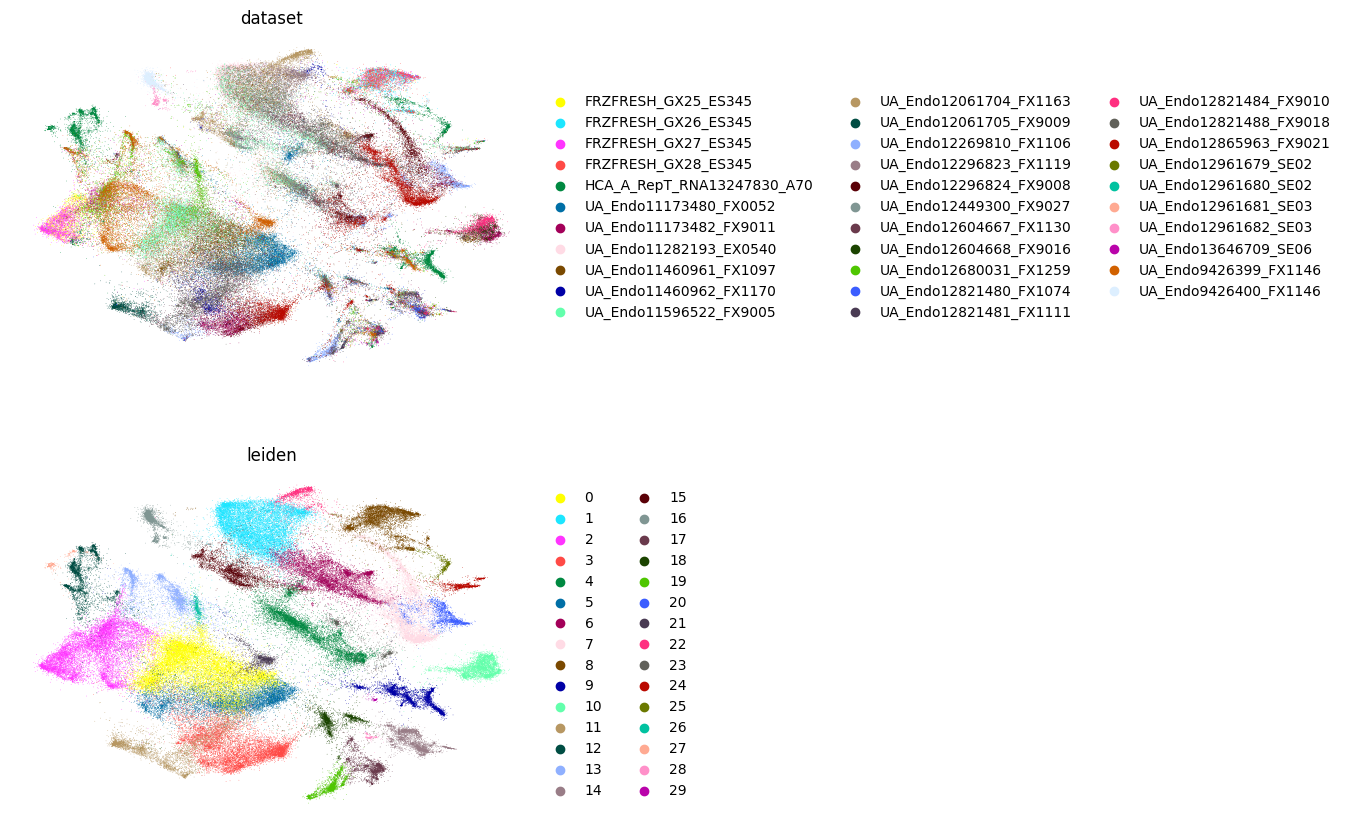

In [ ]:
sc.pl.embedding(
    combined_adata,
    basis=SCVI_MDE_KEY,
    color=["dataset", "leiden_scvi_euc"],
    frameon=False,
    ncols=1,
)

In [ ]:
output_file = scrna_output/dataset_type/"scvi_integrated.h5ad"
combined_adata.write(output_file)
#combined_adata = sc.read(output_file)
